In [1]:
import numpy as np
import os
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import signal

from PIL import Image
import pandas as pd

from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

from glob import glob
from datetime import datetime, timedelta

In [2]:
PATH = Path('../../data')
!ls {PATH}

H1-lines.csv
L1-lines.csv
feats.pkl
gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv
hdf5
images
images_unfilt
input_pipe.pkl
readme.txt
test.hdf5
train.hdf5
val.hdf5


In [3]:
SAMPLE_RATE = 4096.0
K1 = 100/70
NPERSEG = 128
NFFT = 512
WHITEN = True
FILTER = True

# Train, Val, Test Splitting 

In [47]:
data = pd.read_csv(PATH/'gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv'); data.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
0,1.134828e+09,32.246,40.137,1601.119,7.250,3183.373047,LYD73IJEbP,H1,Scattered_Light
1,1.134164e+09,29.897,38.256,2965.068,2.500,5894.235352,kQOi8X6807,H1,Scattered_Light
2,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,Scattered_Light
3,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,Scattered_Light
4,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,Scattered_Light


In [48]:
#data['ifo'] = data['ifo'].map({l:i for i,l in enumerate(set(data.ifo))})
data['label'] = data['label'].map({l:i for i,l in enumerate(sorted(set(data.label)))})
data.rename(index=str, columns={'label':'gen_target'}, inplace=True)

In [49]:
df, test_df = train_test_split(data, test_size=0.33, random_state=7)

In [50]:
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.ifo, random_state=1111)

# Lines 

In [51]:
l1_lines = pd.read_csv(PATH/'L1-lines.csv', sep=','); l1_lines.head()

,f,type,offset,first_harmonic,last_harmonic,left_width,right_width,comment
0,19.15,0,0.0,1,1,0.0003,0.0003,% PR2 pitch line
1,19.65,0,0.0,1,1,0.0003,0.0003,% PR2 yaw line
2,33.70,0,0.0,1,1,0.0003,0.0003,% Calibration line
3,34.70,0,0.0,1,1,0.0003,0.0003,% Calibration line
4,35.30,0,0.0,1,1,0.0003,0.0003,% Calibration line


In [52]:
h1_lines = pd.read_csv(PATH/'H1-lines.csv', sep=','); h1_lines.head()

,f,type,offset,first_harmonic,last_harmonic,left_width,right_width,comment
0,35.9,0,0.0,1,1,0.0003,0.0003,% Calibration line
1,36.7,0,0.0,1,1,0.0003,0.0003,% Calibration line
2,37.3,0,0.0,1,1,0.0003,0.0003,% Calibration line
3,331.9,0,0.0,1,1,0.0003,0.0003,% Calibration line
4,1083.7,0,0.0,1,1,0.0003,0.0003,% Calibration line


In [53]:
l1_lines = l1_lines[(l1_lines.comment !='% Line in the weird comb')]

In [54]:
h1_lines = h1_lines[(h1_lines.comment != '% Unknown comb (strong during Nov 19-21 2015)')]#&(h1_lines.comment != '% Unknown comb (much stronger in arithmetic than in weighted average)')]

In [55]:
def get_freqs(df:pd.DataFrame) -> list:
    freqs = []
    freqs += list(df.loc[df.type==0, 'f'])
    for l in df[df.type==1].values: freqs += [(h+1)*(l[0]+l[2]) for h in range(l[3], l[4])]
    for l in df[df.type==2].values: freqs += [(h+1)*(l[0]+l[2]) for h in range(l[3], l[4])]
    return [f for f in freqs if f < 2080]

In [56]:
h1_freqs = get_freqs(h1_lines)
l1_freqs = get_freqs(l1_lines)
len(h1_freqs), len(l1_freqs)

(849, 678)

In [57]:
for f in set(l1_freqs+h1_freqs):
    nyq = 0.5 * SAMPLE_RATE
    df = 1.0  # pylint: disable=invalid-name
    df2 = 0.1
    low1 = (f - df)/nyq
    high1 = (f + df)/nyq
    low2 = (f - df2)/nyq
    high2 = (f + df2)/nyq
    if low1 < 0 or low1 > 1 or high1 < 0 or high1 > 1 or low2 < 0 or low2 > 1 or high2 < 0 or high2 > 1: print(f, low1, high1, low2, high2)

In [58]:
common_freqs = [f for f in h1_freqs if f in l1_freqs]; len(common_freqs)

35

In [59]:
len(h1_freqs), len(l1_freqs)

(849, 678)

In [60]:
F_MODE = 'h1'
if F_MODE == 'c':
    h1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in common_freqs]
    l1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in common_freqs]
elif F_MODE == 'a':
    h1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in list(set(h1_freqs+l1_freqs))]
    l1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in list(set(h1_freqs+l1_freqs))]
elif F_MODE == 's':
    h1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in h1_freqs]
    l1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in l1_freqs]
elif F_MODE == 'l1':
    h1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in l1_freqs]
    l1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in l1_freqs]
elif F_MODE == 'h1':
    h1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in h1_freqs]
    l1_notches = [filter_design.notch(f, SAMPLE_RATE) for f in h1_freqs]

In [61]:
h1_powernotch = filter_design.concatenate_zpks(*h1_notches)
l1_powernotch = filter_design.concatenate_zpks(*l1_notches)

# Image proc 

In [62]:
def filter_strain(strain:np.ndarray, gps:float, ifo:str) -> np.ndarray:
    ts = TimeSeries(strain, t0=gps, sample_rate=SAMPLE_RATE)
    
    ts = ts.bandpass(50, 250, filtfilt=True)
    
    if FILTER:
        powernotch = h1_powernotch if ifo == 'H1' else l1_powernotch
        ts = ts.filter(powernotch, filtfilt=True)
    if WHITEN: ts = ts.whiten(2, 1)
    return ts

In [63]:
def add_noise_2d(img):
    noise = np.random.randn(img.shape[0]*img.shape[1])
    noise = np.reshape(noise, (img.shape[0], img.shape[1]))
    img += 0.1 * noise
    return img

In [64]:
def proc_strain(strain:np.ndarray, gps:float, ifo:str) -> np.ndarray:
    ts = filter_strain(strain, gps, ifo)
    if Q:
        img = ts.q_transform(frange=(10, 1000)).value
        img = preprocessing.minmax_scale(img)
        img = np.sqrt(img+1)
    else: 
        _, _, img = signal.spectrogram(ts.value, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
        img = np.log(np.sqrt(img))
        if NOISE: img = add_noise_2d(img)
    img = preprocessing.minmax_scale(img)
    img = np.round(255*img).astype(np.uint8)
    img = np.broadcast_to(img[:,:,None],(img.shape[0], img.shape[1],3))
    return img

In [65]:
def create_image(gid:str, gps:float, ifo:str) -> Image:
    name = glob(str(PATH/f'hdf5/*{gid}*'))[0]
    with h5py.File(PATH/f'hdf5/{name}', 'r') as fin: strain = np.array(fin["Strain"]["Strain"].value)
    if np.isnan(np.sum(strain)):
        print(f'{gid} is NaN'); return
    img = proc_strain(strain, gps, ifo)
    return Image.fromarray(img, 'RGB')

In [66]:
def save_image(gid:str, label:str, gps:float, ifo:str) -> None:
    img = create_image(gid, gps, ifo)
    img.save(PATH/f'images/{mode}/{label}/{gid}.png')

In [67]:
for mode in ['train', 'val', 'test']:
    for l in set(data.gen_target): os.makedirs(PATH/'images'/mode/str(l), exist_ok=True)

In [68]:
def proc_sample(df:pd.DataFrame, mode:str) -> None:
    with ProcessPoolExecutor(8) as e: e.map(save_image, df.id.values, df.gen_target, [mode for _ in range(len(df))], df.GPStime, df.ifo)

In [69]:
len(train_df)

3572

In [70]:
len(val_df)

894

In [71]:
len(test_df)

2201

## Check

In [72]:
WHITEN = 1
FILTER = 1
Q = 0
NOISE = 0

In [85]:
gids = [2,3,4,5,6,7,8,9,10,11]
h1_gs = [data[(data.gen_target==t)&(data.ifo=='H1')&(data.id != '5lL68EymOk')&(data.id != 'NOsYE0219V')][0:1] for t in gids]
l1_gs = [data[(data.gen_target==t)&(data.ifo=='L1')&(data.id != 'c0QQ4lWLKD')&(data.id != 'RcF5o0QHMr')][0:1] for t in gids]

In [86]:
for i, g in zip(gids, h1_gs): print(i, g.id[0], g.GPStime[0], g.ifo[0])
for i, g in zip(gids, l1_gs): print(i, g.id[0], g.GPStime[0], g.ifo[0])

2 RiTNwU1wPp 1126587927.102 H1
3 m44eQDjFmi 1136353325.804 H1
4 BTGpb9EV7L 1128668902.983 H1
5 QplZEVqy9R 1132613193.792 H1
6 NOsYE0219V 1127306442.52 H1
7 0X7Yj90rXc 1132250196.6 H1
8 1ibSM4r6gF 1136406575.07 H1
9 WWPHlPTAT8 1135052410.922 H1
10 bKFmvaun4W 1135370942.625 H1
11 YqVpLz4l6B 1134494333.477 H1
2 JIFqGQ3R1t 1134155188.383 L1
3 6zEEDplpiy 1136399217.944 L1
4 MmvzgzyMfu 1128668902.99 L1
5 goQWqytlBn 1131343302.219 L1
6 RcF5o0QHMr 1128421852.801 L1
7 jfrr6Q4NEG 1132782971.826 L1
8 JzwxwVd6zT 1136695549.949 L1
9 6OLc5h01c9 1131724219.219 L1
10 FJLZDNumdb 1133013232.875 L1
11 q08wiy8uNZ 1134154856.34 L1


In [87]:
%%capture --no-stdout
h1_imgs = [create_image(g.id[0], g.GPStime[0], g.ifo[0]) for g in h1_gs]
l1_imgs = [create_image(g.id[0], g.GPStime[0], g.ifo[0]) for g in l1_gs]

NOsYE0219V is NaN
RcF5o0QHMr is NaN


TypeError: Image data cannot be converted to float

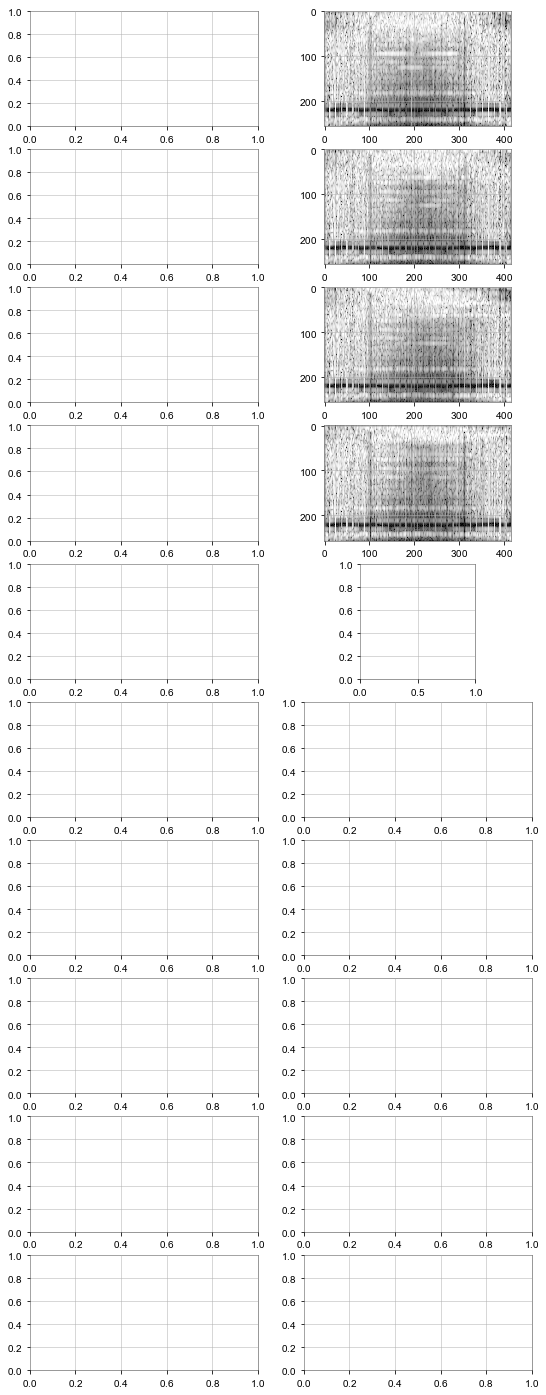

In [84]:
#h1
fig, axs = plt.subplots(len(gids), 2, figsize=(9,25))
for i, ax in enumerate(axs[:,1]): ax.imshow(l1_imgs[i])
for i, ax in enumerate(axs[:,0]): ax.imshow(h1_imgs[i])

In [41]:
ns = [len(train_df[train_df.gen_target==c]) for c in sorted(set(train_df.gen_target))]
np.argmin(ns), np.min(ns)

(4, 3)

In [42]:
for c,n in enumerate(ns): print(c,n)

0 45
1 267
2 384
3 152
4 3
5 203
6 954
7 80
8 54
9 41
10 30
11 244
12 15
13 9
14 26
15 78
16 75
17 285
18 238
19 27
20 148
21 214


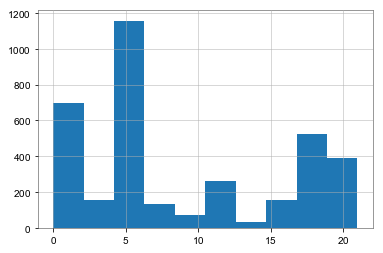

In [43]:
train_df.gen_target.hist()

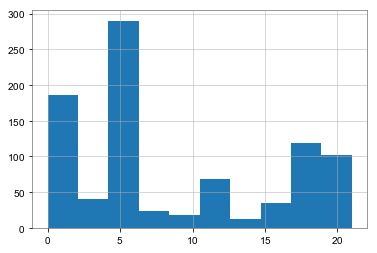

In [44]:
val_df.gen_target.hist()

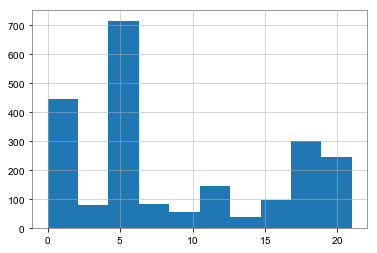

In [45]:
test_df.gen_target.hist()

## Process

In [21]:
%%capture --no-stdout
proc_sample(train_df, 'train')

In [25]:
%%capture --no-stdout
proc_sample(val_df, 'val')

In [26]:
%%capture --no-stdout
proc_sample(test_df, 'test')

# Testing 

In [218]:
gid = 'bdjBbWwqDG'
gid = 'T8Envi8aOu'
gps = data.loc[data.id==gid, 'GPStime'].values[0]
ifo = data.loc[data.id==gid, 'ifo'].values[0]
name = glob(str(PATH/f'hdf5/*{gid}*'))[0]
with h5py.File(PATH/f'hdf5/{name}', 'r') as fin: strain = np.array(fin["Strain"]["Strain"].value)

In [219]:
FILTER = 1
WHITEN = 0
ts = filter_strain(strain, gps, ifo)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [207]:
ts = ts.lowpass(750)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


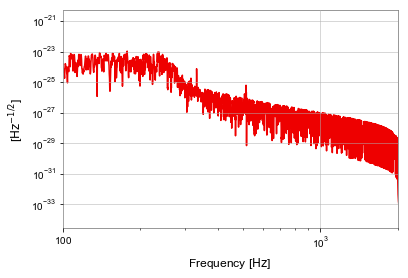

In [227]:
plot2 = ts.asd(fftlength=3).plot(color='gwpy:ligo-hanford')
ax = plot2.gca()
ax.set_xlim(100, 2000)
ax.set_ylim(3e-35, 5e-21)
plot2.show()

Text(0, 0.5, 'Strain')

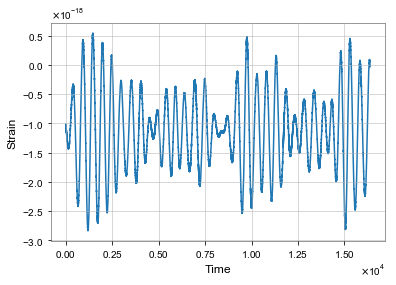

In [462]:
plt.plot(np.arange(len(strain)), strain)
plt.xlabel("Time")
plt.ylabel("Strain")

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


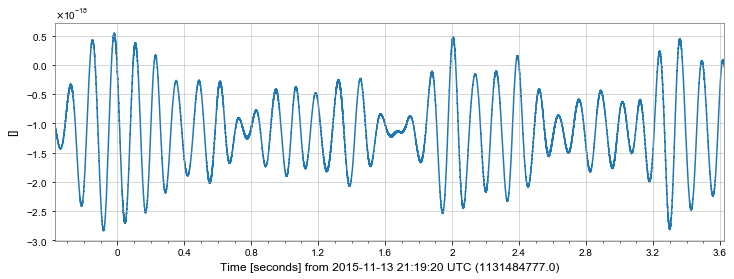

In [463]:
hdata = TimeSeries(strain, t0=gps,
                   sample_rate=SAMPLE_RATE)
plot = hdata.plot()
plot.show()

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


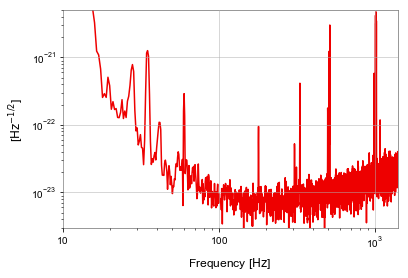

In [464]:
hasd = hdata.asd(fftlength=2)
plot2 = hasd.plot(color='gwpy:ligo-hanford')
ax = plot2.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(3e-24, 5e-21)
plot2.show()

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


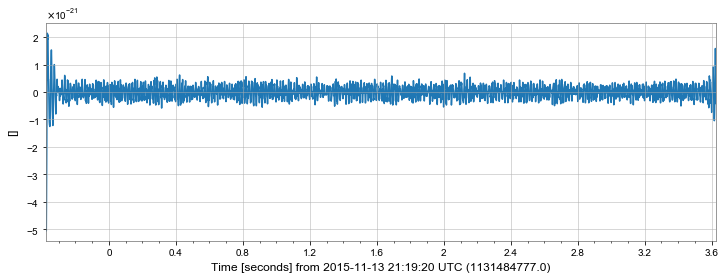

In [465]:
hbp = hdata.bandpass(50, 250, filtfilt=True)
plot = hbp.plot()

freqs = [60, 120, 180,
         500, 1000, 1500, 2000,
         9, 13.8,
         300, 600, 900]
if datetime(1980, 1, 6) + timedelta(seconds=gps - (35 - 19)) <= datetime(2015, 9, 13):
    freqs += [600.1, 625.1, 650.1, 675.1]
    
if ifo == 'H1':
    freqs += [35.9000, 36.7000, 37.3000, 331.900, 1083.700]
    freqs += [8]
else:
    freqs += [33.7000, 34.7000, 35.3000, 331.300, 1083.100]
    freqs += [n*22.7 for n in range(1, int(1000/22.7))] + [n*25.6 for n in range(1, int(1000/25.6))]
notches = [filter_design.notch(f, hdata.sample_rate) for f in freqs]
powernotch = filter_design.concatenate_zpks(*notches)
hclean = hbp.filter(powernotch, filtfilt=True)

In [466]:
def get_freqs(df:pd.DataFrame) -> list:
    freqs = list(df.loc[df.type==0, 'f'])
    for l in df[df.type==1].values: freqs += [((h+1)*l[0])+l[2] for h in range(l[3], l[4])]
    for l in df[df.type==2].values: freqs += [(((h+1)*l[0])+l[2])-(h+1) for h in range(l[3], l[4])]
    return freqs

In [483]:
freqs = get_freqs(h1_lines if ifo == 'H1' else l1_lines)
notches = [filter_design.notch(f, hdata.sample_rate) for f in freqs]
powernotch = filter_design.concatenate_zpks(*notches)
hclean = hbp.filter(powernotch, filtfilt=True)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


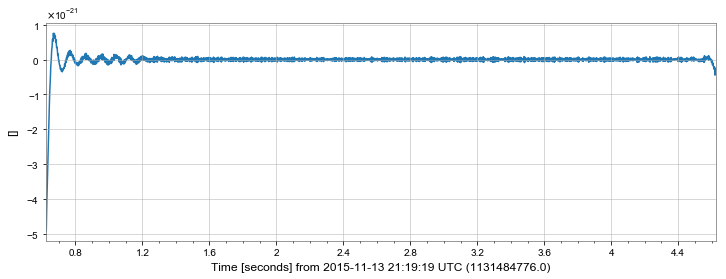

In [484]:
plot = hclean.plot()
ax = plot.gca()
ax.set_epoch(int(gps))

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


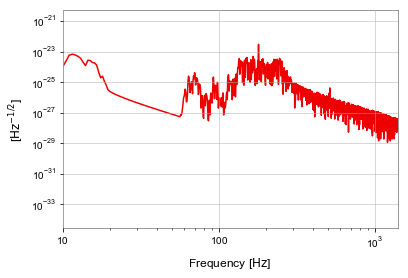

In [485]:
hasd = hclean.asd(fftlength=2)
plot2 = hasd.plot(color='gwpy:ligo-hanford')
ax = plot2.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(3e-35, 5e-21)
plot2.show()

In [486]:
a = hasd.value
b = [f for f in a ]

In [487]:
whitened = hclean.crop(gps+0.5, gps+3.8).whiten(2,1)

In [488]:
whitened = hclean.whiten(2, 1)

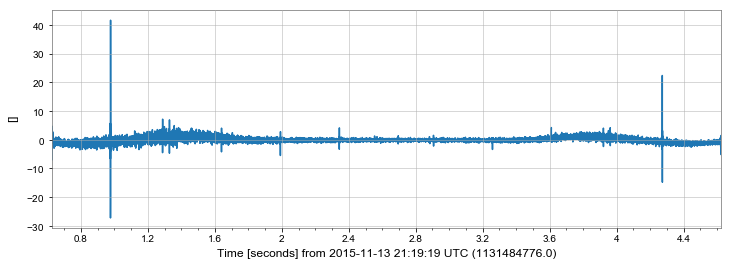

In [489]:
plot = whitened.plot()
ax = plot.gca()
ax.set_epoch(int(gps))

In [490]:
hq = whitened.q_transform(frange=(10, 1000))

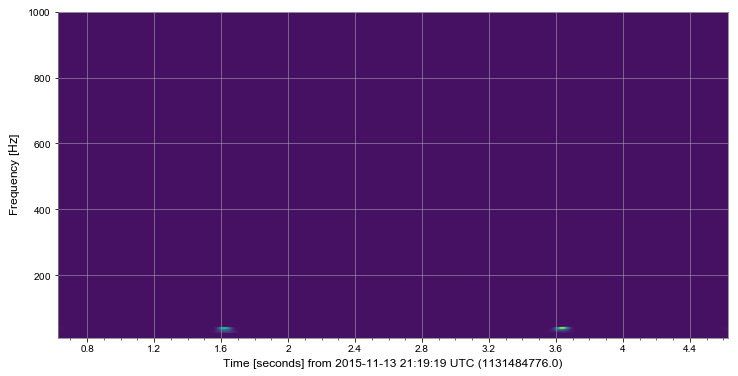

In [491]:
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(int(gps))

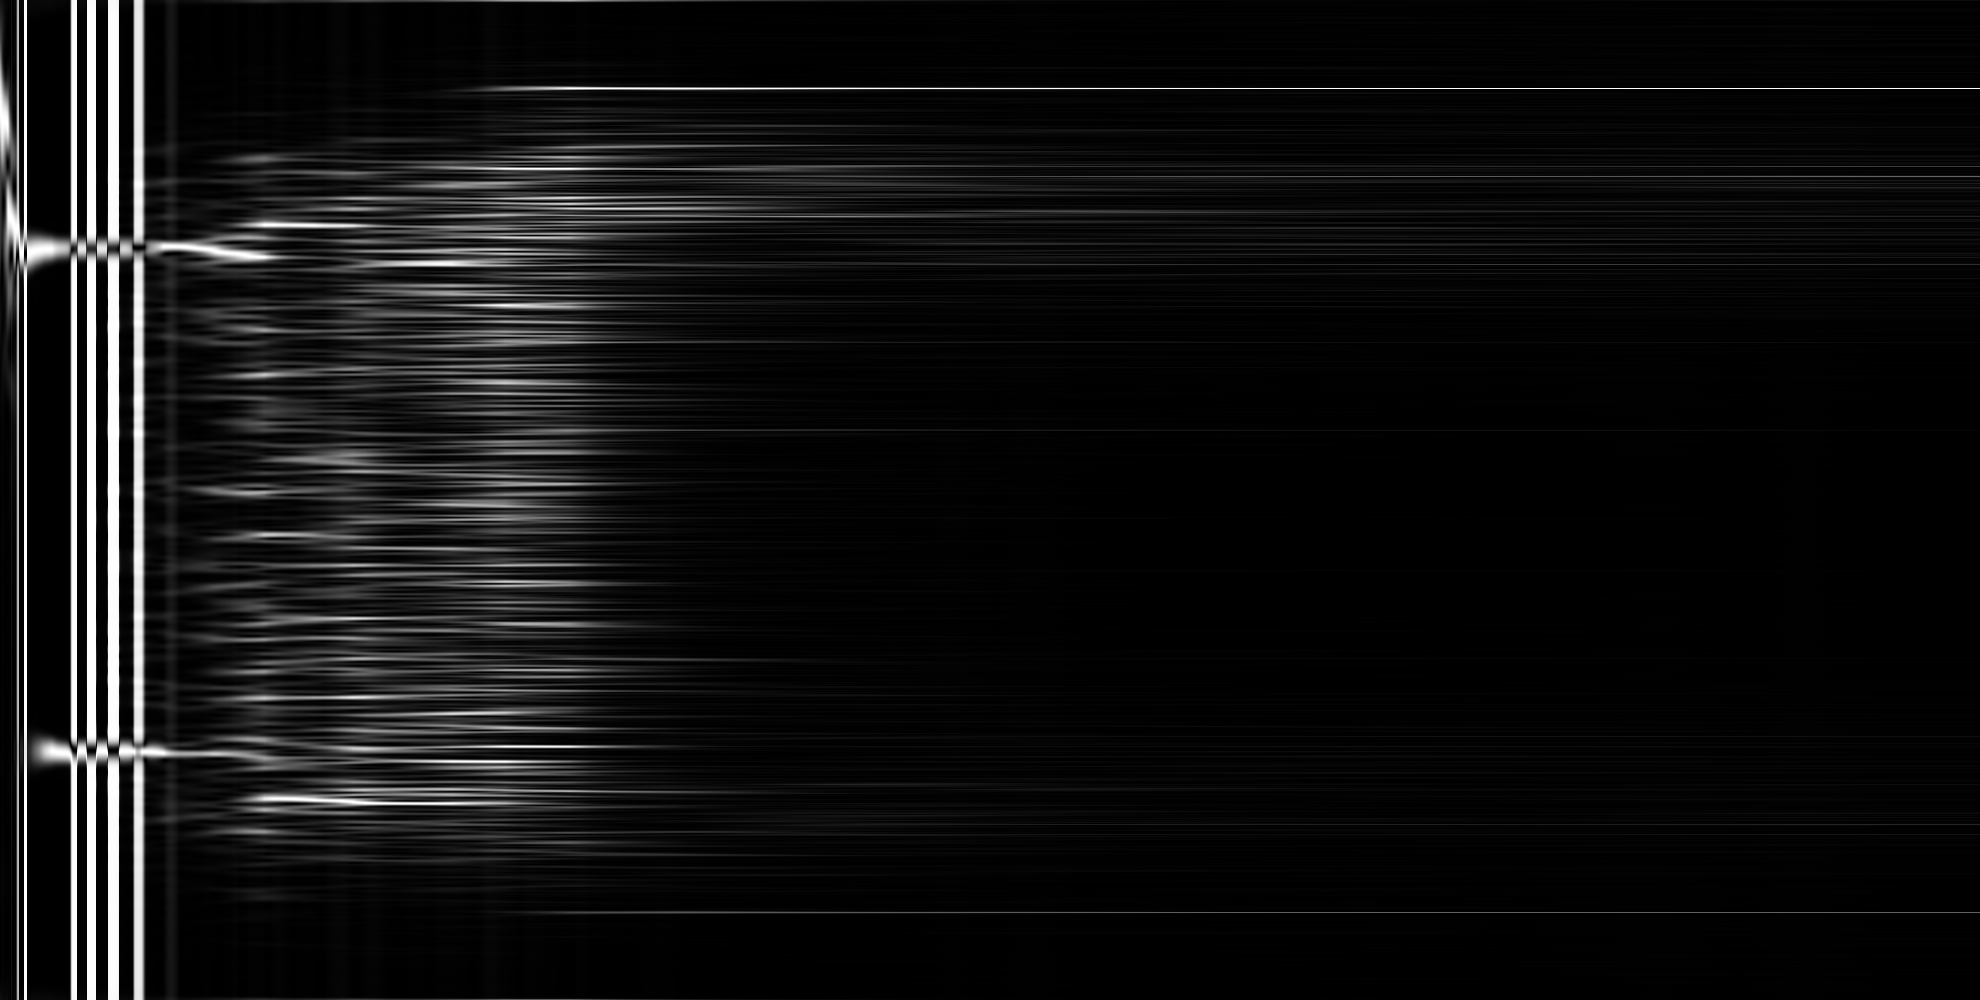

In [492]:
img = hq.value
img = preprocessing.minmax_scale(img)
img = np.log(np.sqrt(img+1))
img = preprocessing.minmax_scale(img)
img = np.round(255*img).astype(np.uint8)
img = np.broadcast_to(img[:,:,None],(img.shape[0], img.shape[1],3))
Image.fromarray(img, 'RGB')

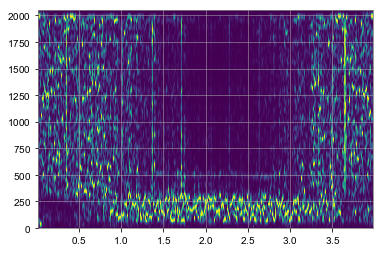

In [493]:
f, t, img = signal.spectrogram(whitened.value, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, preprocessing.minmax_scale(img))

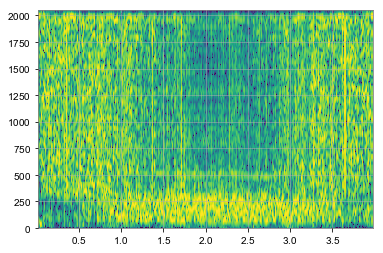

In [494]:
f, t, img = signal.spectrogram(whitened.value, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, preprocessing.minmax_scale(np.log(np.sqrt(img))))